1. Load mol objects and highlight sites that are being misclassified
2. A lot of the false positives are tertiary carbon atoms with high spin. Tertiary carbon atoms don't usually do as well, but the model can't tell the difference between T-carbons embedded in rings or connected to methyl groups. This could deserve its own feature
3. A lot of the false negatives are for small molecules with multiple nitrogen atoms. Correcting the aromatic ring size feature could potentially improve this. First check if the RDKit feature is trustworthy; if not, can just look for the full set of carbons with only 3 bonds, as these are necessarily sp2.
4. The aromatic ring size features appears to be completely wrong, and I found at least one counterexample for OrthoOrPara. DistanceToN may obviate OrthoOrPara anyway
5. sf189x0 has an active site at carbon 4 (binding energy -0.1eV), and a symmetric site at carbon 21 that is not active. This likely illustrates different conformers can subtely affect these energies
6. Catalyst sf41x0 lists all binding sites as inactive, but some actually are (and possibly most). If I move the correct files to the correct directory, can I just rerun Kunal's parsing scripts?

Score to beat: 95% w/ random forest on 10-fold cross validation
Since 80% of sites are not active, the threshold for success is 80%

In [1]:
import pandas as pd
import numpy as np

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GroupKFold

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier

# Regression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Data Analysis
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

from ngcc_ml import data_tools

In [2]:
def processData(df_in, oneHotCols=[], scaledCols=[]):
    df = df_in.copy()
    scaler = StandardScaler()
    oneHotEncoder = OneHotEncoder(categories = "auto", sparse = False)
    if scaledCols != []:
        df[scaledCols] = scaler.fit_transform(df[scaledCols])
    #if oneHotCols != []:
    #    df[encoded_columns] = oneHotEncoder.fit_transform(alldata[oneHotCols])
    return df

def group_split_evaluate(model, df_xy, feature_cols, target_col="Doesitbind", n_splits=10, group_col="Catalyst Name"):
    all_scores = []
    split_groups = GroupShuffleSplit(test_size=0.10, n_splits=n_splits, random_state = 7).split(df, groups=df[group_col])
    for train_inds, test_inds in split_groups:
        train = df_xy.iloc[train_inds]
        test = df_xy.iloc[test_inds]
        X_train_group = train[feature_cols]
        X_test_group = test[feature_cols]
        y_test_group = test[target_col]
        y_train_group = train[target_col]
        model.fit(X_train_group, y_train_group)
        score = model.score(X_test_group, y_test_group)
        all_scores.append(score)
        print('Accuracy of RFC on test set: {:.2f}'.format(score))
        print('Accuracy of RFC on training set: {:.2f}'.format(model.score(X_train_group, y_train_group)))
    print("mean:", np.mean(all_scores))
    
def group_kfold_evaluate(model, df_xy, feature_cols, target_col="Doesitbind", n_splits=10, group_col="Catalyst Name"):
    all_scores, all_test_idxs, all_y_test_pred = [], [], []
    all_perm_importance = []
    split_groups = GroupKFold(n_splits=n_splits).split(df[feature_cols], df[target_col], df[group_col])
    for train_inds, test_inds in split_groups:
        train = df_xy.iloc[train_inds]
        test = df_xy.iloc[test_inds]
        X_train_group = train[feature_cols]
        X_test_group = test[feature_cols]
        y_test_group = test[target_col]
        y_train_group = train[target_col]
        model.fit(X_train_group, y_train_group)
        score = model.score(X_test_group, y_test_group)
        y_test_pred = model.predict(X_test_group)
        perm_importance = permutation_importance(model, X_test_group, y_test_group, n_repeats=10)
        all_test_idxs.append(test)
        all_y_test_pred.append(y_test_pred)
        all_scores.append(score)
        all_perm_importance.append(perm_importance)
        print('Accuracy of RFC on test set: {:.2f}'.format(score))
        print('Accuracy of RFC on training set: {:.2f}'.format(model.score(X_train_group, y_train_group)))
    print("mean:", np.mean(all_scores))
    return all_scores, all_test_idxs, all_y_test_pred, all_perm_importance

In [3]:
df = pd.read_csv("/home/nricke/work/ngcc_ml/DidItBindv5.csv", index_col=0)
df = df[df["Catalyst Name"] != "sf7x0"]

In [24]:
feature_cols = ["SpinDensity", "ChElPGNeutralCharge", "ChargeDifference", "IonizationEnergy", "OrthoOrPara", "Meta", "FartherThanPara", "DistanceToN", "NumberOfHydrogens", "IsInRingSize6", "IsInRingSize5", "NeighborSpinDensity", 'NeighborChElPGCharge', 'NeighborChargeDifference', "AromaticExtent", "RingEdge", "NumNitrogens", "NumHeteroatoms", "charge", "atom_plane_deviation", "ring_plane_deviation", "ring_nitrogens"]
not_scaled_cols = ["OrthoOrPara", "Meta", "FartherThanPara", "NumberOfHydrogens", "IsInRingSize6", "IsInRingSize5", "RingEdge", "NumNitrogens", "NumHeteroatoms", "ring_nitrogens", "charge"]
#df_scale = processData(df, scaledCols=list(feature_cols - not_scaled_cols))

In [25]:
rfc = RandomForestClassifier(n_estimators=1000, max_depth=100, class_weight={0:0.5, 1:0.5})
gkf_scores, gkf_test_idxs, gkf_test_pred, gkf_permute = group_kfold_evaluate(rfc, df, feature_cols, "Doesitbind")

Accuracy of RFC on test set: 0.96
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.95
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.94
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.95
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.97
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.96
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.95
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.95
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.93
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.95
Accuracy of RFC on training set: 1.00
mean: 0.9502897754243993


In [26]:
gkf_permute[0].importances.shape

(22, 10)

In [27]:
gkf_permute

[{'importances_mean': array([ 0.01923077,  0.00793269,  0.03533654,  0.00144231,  0.01298077,
         -0.00144231,  0.00216346,  0.01057692,  0.00264423,  0.00072115,
          0.        ,  0.00144231,  0.00336538,  0.00264423,  0.00120192,
          0.01346154, -0.00192308,  0.        ,  0.        ,  0.00432692,
          0.00480769, -0.00048077]),
  'importances_std': array([0.00456098, 0.00305014, 0.0066313 , 0.00445847, 0.00390579,
         0.00159453, 0.00250969, 0.00375493, 0.00129451, 0.00110158,
         0.        , 0.00419125, 0.00117764, 0.00129451, 0.00268758,
         0.00390579, 0.00209562, 0.        , 0.        , 0.00280334,
         0.00372402, 0.00179887]),
  'importances': array([[ 0.02884615,  0.02403846,  0.02403846,  0.01442308,  0.01682692,
           0.01442308,  0.01682692,  0.01923077,  0.01682692,  0.01682692],
         [ 0.00961538,  0.00721154,  0.00961538,  0.00240385,  0.00480769,
           0.00721154,  0.00721154,  0.00961538,  0.01442308,  0.00721154],


In [34]:
imp_mean = np.zeros(gkf_permute[0].importances.shape)
imp_std_mean = np.zeros(gkf_permute[0].importances_std.shape)

for i in range(len(gkf_permute)):
    imp_mean += gkf_permute[i].importances
    imp_std_mean += gkf_permute[i].importances_std
    
imp_mean /= gkf_permute[0].importances.shape[1]
imp_std_mean /= gkf_permute[0].importances_std.shape

In [35]:
imp_mean.shape

(22, 10)

In [36]:
"""
tree_importance_sorted_idx = np.argsort(rfc.feature_importances_)
print(tree_importance_sorted_idx)
tree_indices = np.arange(0, len(rfc.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices,
         rfc.feature_importances_[tree_importance_sorted_idx], height=0.7)
"""

'\ntree_importance_sorted_idx = np.argsort(rfc.feature_importances_)\nprint(tree_importance_sorted_idx)\ntree_indices = np.arange(0, len(rfc.feature_importances_)) + 0.5\n\nfig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))\nax1.barh(tree_indices,\n         rfc.feature_importances_[tree_importance_sorted_idx], height=0.7)\n'

In [11]:
np.mean(np.ones((3,3)), axis=0)

array([1., 1., 1.])

In [12]:
"""
#feature_names = np.array(list(feature_cols))
feature_names = ["Aromatic Planar Deviation", "Aromatic Nitrogens", "Atom Planar Deviation", "Neighbor Charge Difference",
                "Neutral Partial Charge", "Molecule Nitrogens Count", "Nearest Nitrogen Distance", "Molecule Heteroatom Count", 
                "Neighbor Spin Density", "Ionization Energy", "Meta", "Ortho or Para", "Spin Density", "Hydrogen Count",
                "Aromatic Extent", "Farther than Para", "Ring Edge", "Charge Difference", "Is in Ring Size 6", "Molecule Charge",
                "Is in Ring Size 5", "Neighbor Partial Charge"]
feature_names = np.array(feature_names)
"""

In [42]:
feature_names = [
    "Spin Density",
    "Neutral Partial Charge",
    "Partial Charge Difference",
    "Ionization Energy",
    "Ortho or Para",
    "Meta",
    "Farther than Para",
    "Nearest Nitrogen Distance",
    "Hydrogen Count",
    "Is in Ring Size 6",
    "Is in Ring Size 5",
    "Neighbor Spin Density",
    "Neighbor Partial Charge",
    "Neighbor Charge Difference",
    "Aromatic Extent",
    "Ring Edge",
    "Molecule Nitrogens Count",
    "Molecule Heteroatom Count",
    "Molecule Charge",
    "Atom Planar Deviation",
    "Aromatic Nitrogens",
    "Ring Nitrogens"
    ]
feature_names = np.array(feature_names)

In [38]:
list(feature_cols)

['SpinDensity',
 'ChElPGNeutralCharge',
 'ChargeDifference',
 'IonizationEnergy',
 'OrthoOrPara',
 'Meta',
 'FartherThanPara',
 'DistanceToN',
 'NumberOfHydrogens',
 'IsInRingSize6',
 'IsInRingSize5',
 'NeighborSpinDensity',
 'NeighborChElPGCharge',
 'NeighborChargeDifference',
 'AromaticExtent',
 'RingEdge',
 'NumNitrogens',
 'NumHeteroatoms',
 'charge',
 'atom_plane_deviation',
 'ring_plane_deviation',
 'ring_nitrogens']

In [41]:
print(len(feature_names))
print(len(feature_cols))

22
22


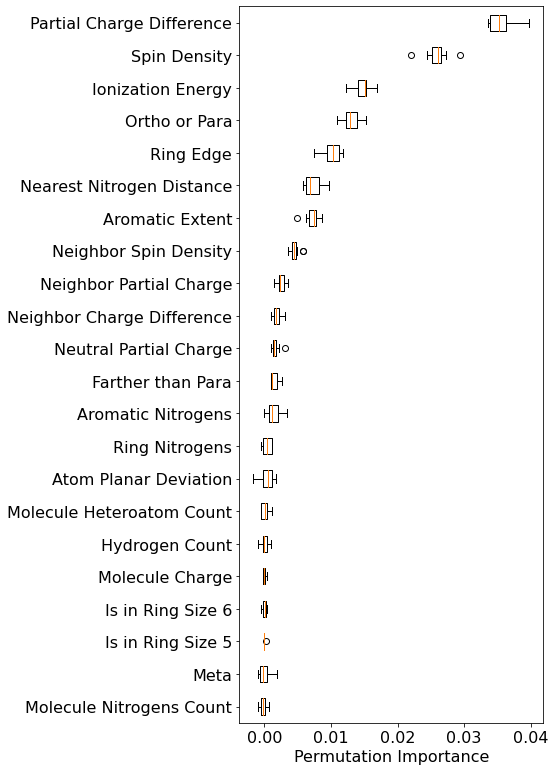

In [46]:
# we should be able to average the values from each of the k-folds
plt.rcParams.update({'figure.autolayout': True})

imp_mean_mean = np.mean(imp_mean, axis=1)
perm_sorted_idx = imp_mean_mean.argsort()

fig = plt.gcf()
#fig, ax = plt.subplot(1,1)
#ax.set_yticklabels(features[tree_importance_sorted_idx])
#ax.set_yticks(tree_indices)
#ax.set_ylim((0, len(rfc.feature_importances_)))
#plt.boxplot(imp_mean[0:10].T, vert=False)
plt.boxplot(imp_mean[perm_sorted_idx].T, vert=False,
            labels=feature_names[perm_sorted_idx])
#fig.tight_layout()
fig.set_size_inches(8,11)
plt.xlabel("Permutation Importance")
plt.savefig("RFC_permutation_importance.png")
#plt.show()


In [15]:
gkf_test = pd.concat(gkf_test_idxs)

In [16]:
gkf_test_pred_list = []
for gkf in gkf_test_pred:
    gkf_test_pred_list += list(gkf)

In [17]:
gkf_test["Doesitbind_pred"] = gkf_test_pred_list

In [18]:
#train_inds, test_inds = next(GroupShuffleSplit(test_size=0.10, n_splits=2, random_state = 7).split(df_active, groups=df_active['Catalyst Name']))

In [19]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.neural_network import MLPRegressor

In [20]:
#kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
#gpr = GaussianProcessRegressor(n_restarts_optimizer=9)
model = MLPRegressor(max_iter=30000, hidden_layer_sizes=(512, 256, 128, 16), learning_rate="adaptive")
#model.fit(X_reg_train_group, y_reg_train_group)
#y_reg_test_group_pred = model.predict(X_reg_test_group)
#mse = mean_squared_error(y_reg_test_group, y_reg_test_group_pred, squared=False)
#mae = mean_absolute_error(y_reg_test_group, y_reg_test_group_pred)
#print(mse, mae)



#group_split_evaluate(gpr, df_active, feature_cols, "BindingEnergy")

In [21]:
r2_score(y_reg_test_group, y_reg_test_group_pred)

NameError: name 'y_reg_test_group' is not defined

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_reg_test_group, y_reg_test_group_pred)
plt.plot([-1.1,0],[-1.1,0.], color="black")
plt.ylim([-1.1,0])
plt.xlim([-1.1,0])
plt.show()

In [ ]:
y_reg_test_group

In [ ]:
y_reg_train_group.min()

In [ ]:
y_pred = rfc.predict(X_test)

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
# Get indices of misclassified active sites
X_test_y = X_test.copy()
X_test_y["y_pred"] = y_pred
X_test_y["y_test"] = y_test

In [ ]:
X_test_y

In [ ]:
dfy = df.merge(X_test_y[["y_pred", "y_test"]], how="inner", left_index=True, right_index=True)

In [ ]:
dfy_miss = dfy[dfy["y_pred"] != dfy["y_test"]]
dfy_false_pos = dfy_miss[dfy_miss["y_pred"] == 1]
dfy_false_neg = dfy_miss[dfy_miss["y_pred"] == 0]

In [ ]:
dfy_false_neg[["Atom Number", "Catalyst Name", "BindingEnergy", "IonizationEnergy", "SpinDensity", "AromaticExtent", "RingEdge", "DistanceToN"]].sort_values(by="Catalyst Name")

In [ ]:
dfy_false_pos[["Atom Number", "Catalyst Name", "BindingEnergy", "IonizationEnergy", "SpinDensity", "Meta", "OrthoOrPara", "DistanceToN", "NumberOfHydrogens", "AromaticExtent", "RingEdge"]].sort_values(by="Catalyst Name")

In [ ]:
mlp = MLPClassifier(max_iter=20000, hidden_layer_sizes = (400,400,200,100,100), alpha=0.1)
mlp.fit(X_train, y_train)
print('Accuracy of MLP classifier on test set: {:.2f}'.format(mlp.score(X_test, y_test)))
print('Accuracy of MLP classifier on training set: {:.2f}'.format(mlp.score(X_train, y_train)))
#scores = cross_val_score(mlp, X, y, cv=10)
#print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
mlp = MLPClassifier(max_iter=15000, hidden_layer_sizes = (2048, 1024, 512, 15), alpha=0.1)
mlp.fit(X_train, y_train)
print('Accuracy of MLP classifier on test set: {:.2f}'.format(mlp.score(X_test, y_test)))
print('Accuracy of MLP classifier on training set: {:.2f}'.format(mlp.score(X_train, y_train)))
scores = cross_val_score(mlp, X, y, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))